# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [3]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [4]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [5]:
!hdfs dfs -copyFromLocal data .

In [6]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 16:22 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 16:22 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 16:22 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 16:22 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 16:22 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 16:22 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 16:22 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 16:22 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 16:22 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
%%time
ratings.take(5)

CPU times: user 10.3 ms, sys: 791 µs, total: 11.1 ms
Wall time: 1.87 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 25.4 ms, sys: 118 µs, total: 25.5 ms
Wall time: 1min 11s


162541

Сохраним датасет в память

In [11]:
ratings = ratings.persist()

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 22.7 ms, sys: 5.15 ms, total: 27.9 ms
Wall time: 1min 55s


162541

Количество фильмов

In [16]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 7.71 ms, sys: 9.45 ms, total: 17.2 ms
Wall time: 32.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [12]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [13]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (175085, (5.0, ['175085', 'New Order (2012)'])),
 (179621, (5.0, ['179621', 'Frau Holle (2008)'])),
 (182589, (5.0, ['182589', 'Witchcraft 15: Blood Rose (2017)'])),
 (166223, (5.0, ['166223', '"Von einem']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [14]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [15]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 16:27 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59127 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112211 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131266 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114148 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133716 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117803 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143080 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132136 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167847 2021-02-17 16:27 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [16]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [17]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [18]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

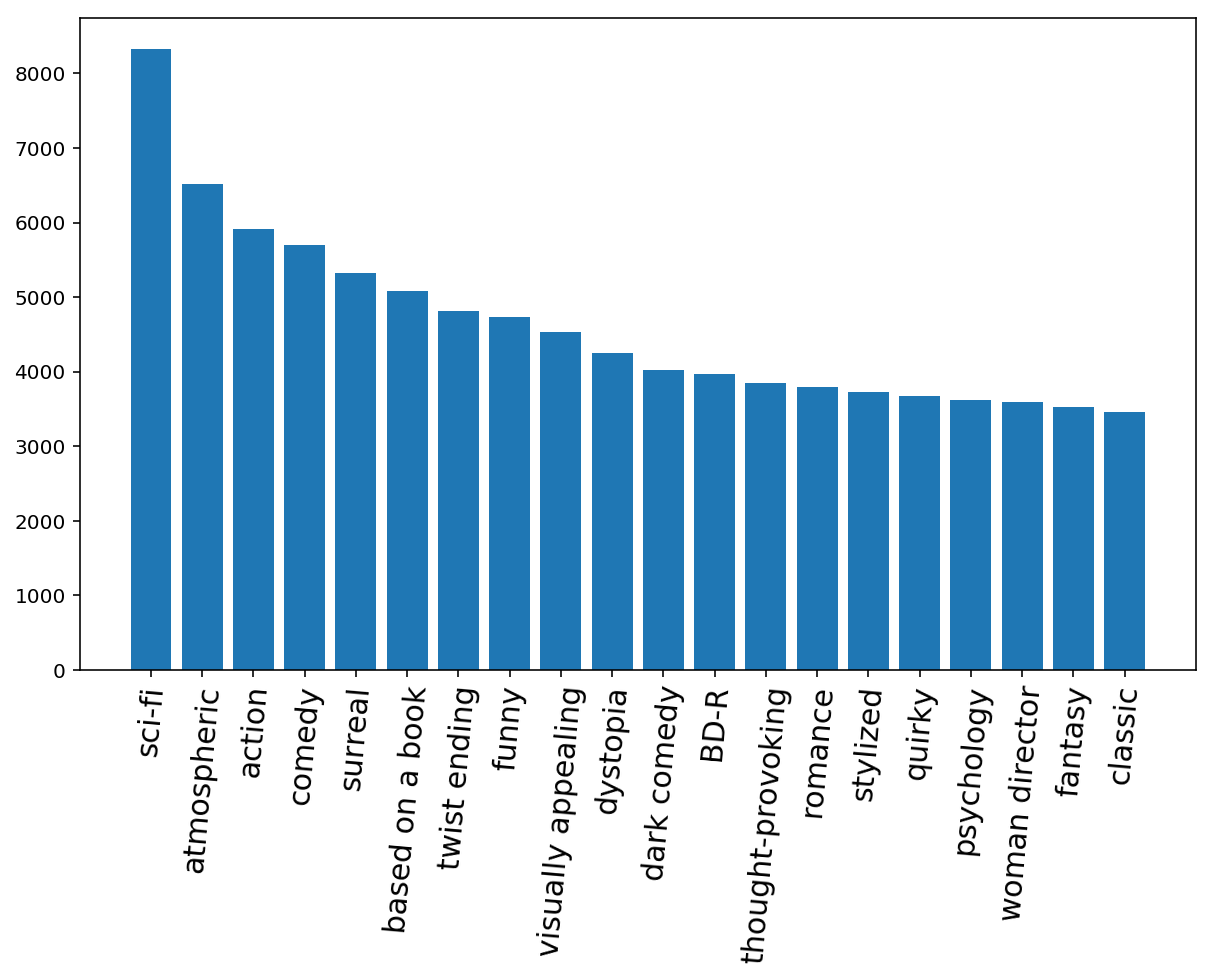

In [19]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [20]:
import operator
from operator import add

In [21]:
######################################
######### YOUR CODE HERE #############
######################################

movie_marks = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(add)

In [23]:
movie_marks.join(movies).sortBy(lambda x: -x[1][0]).take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [24]:
######################################
######### YOUR CODE HERE #############
######################################

movie_five = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(add)


In [25]:
movie_five.join(movies).sortBy(lambda x: -x[1][0]).take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

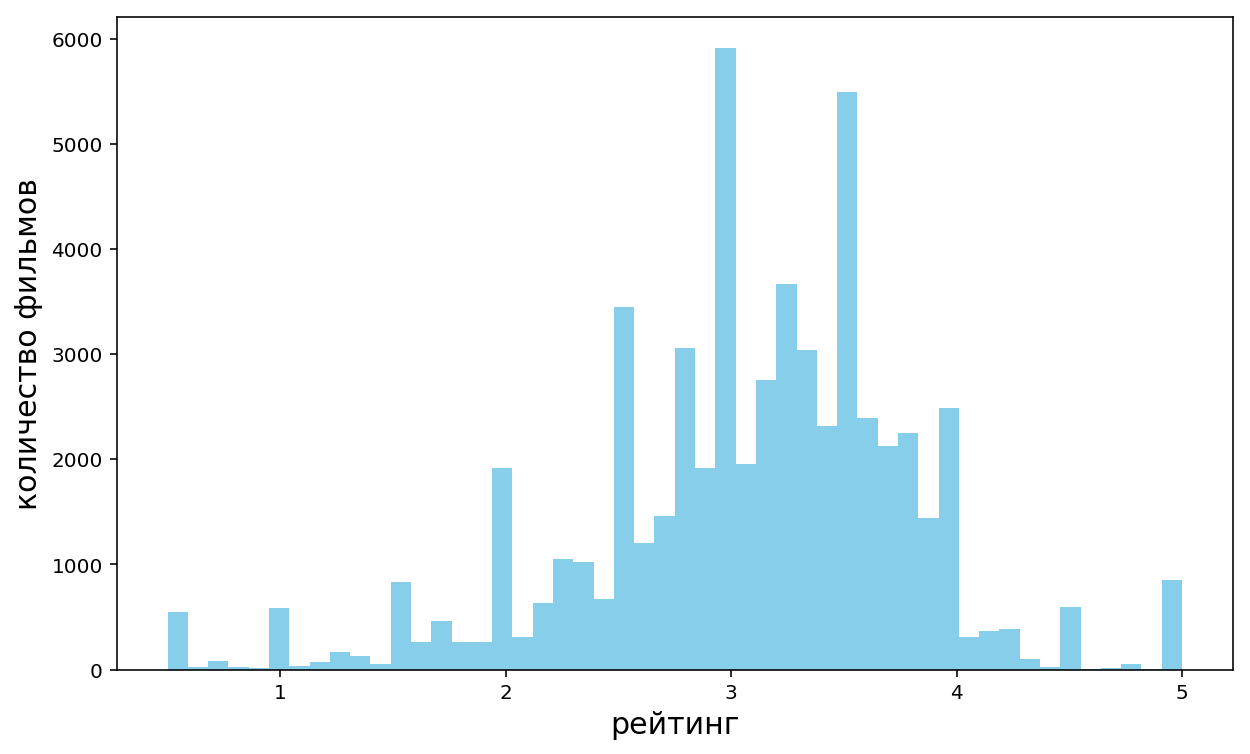

In [27]:
######################################
######### YOUR CODE HERE #############
######################################

hist_movie_avg = movie_avg_rating.values().collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(hist_movie_avg, bins = 50, color = 'skyblue')
plt.xlabel('рейтинг', fontsize=15)
plt.ylabel('количество фильмов', fontsize=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

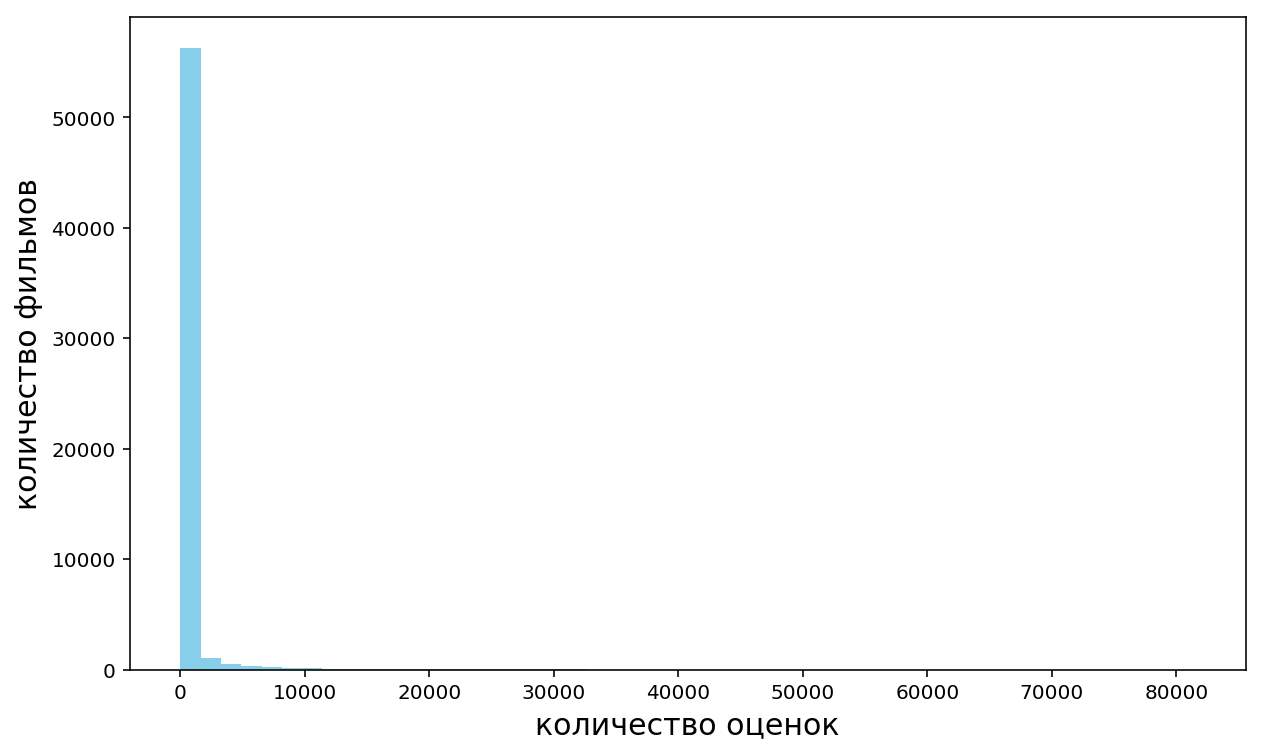

In [28]:
######################################
######### YOUR CODE HERE #############
######################################

hist_movie_marks = movie_marks.values().collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(hist_movie_marks, bins = 50, color = 'skyblue')
plt.xlabel('количество оценок', fontsize=15)
plt.ylabel('количество фильмов', fontsize=15)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [29]:
######################################
######### YOUR CODE HERE #############
######################################


movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(','))
movies.take(3)

[['movieId', 'title', 'genres'],
 ['1', 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'],
 ['2', 'Jumanji (1995)', 'Adventure|Children|Fantasy']]

In [30]:
num_genres = movies\
    .flatMap(lambda x: x[-1].split('|'))\
    .map(lambda x: (x,1))\
    .reduceByKey(add)

In [31]:
num_genres.take(100)

[('Sci-Fi', 3595),
 ('Horror', 5989),
 ('Drama', 25606),
 ('Action', 7348),
 ('Western', 1399),
 ('Children', 2935),
 ('Musical', 1054),
 ('Documentary', 5605),
 ('Thriller', 8654),
 ('Fantasy', 2731),
 ('Romance', 7719),
 ('IMAX', 195),
 ('genres', 1),
 ('(no genres listed)', 5062),
 ('Adventure', 4145),
 ('Comedy', 16870),
 ('Crime', 5319),
 ('War', 1874),
 ('Animation', 2929),
 ('Mystery', 2925),
 ('Film-Noir', 353)]

In [32]:
genres, movies_number = zip(*sorted(num_genres.collect(), key= lambda x:x[1], reverse=True))

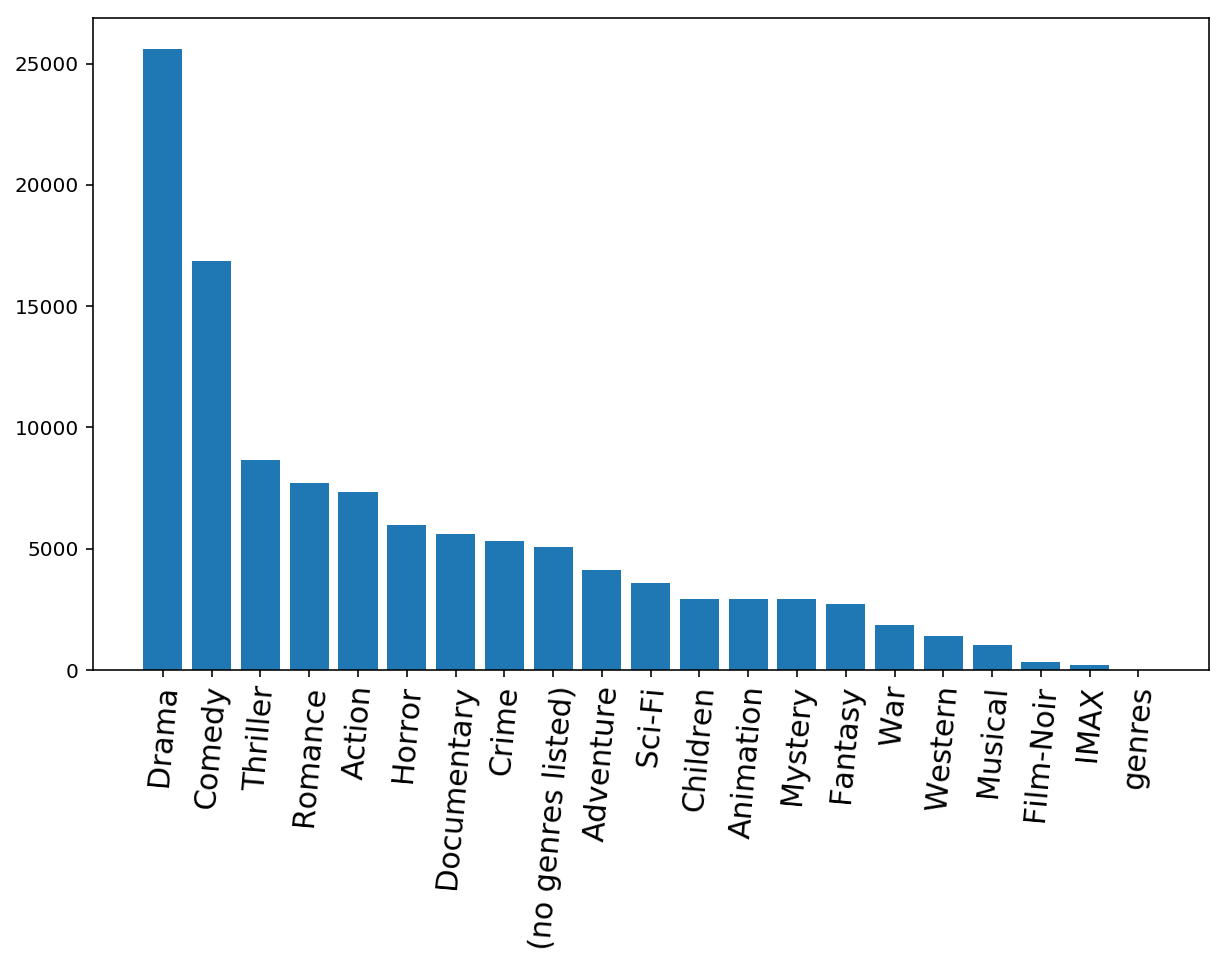

In [33]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, movies_number, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [34]:
movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda x: x[0].isdigit()) \
    .keyBy(lambda x: int(x[0]))

In [35]:
movies.take(3)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)'])]

In [37]:
######################################
######### YOUR CODE HERE #############
######################################

LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

links = sc.textFile(LINKS_PATH)
links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda x: x[0].isdigit() and x[2].isdigit()) \
    .map(lambda x: (int(x[2]), int(x[0])))
tmdb = sc.textFile(TMDB_PATH)

In [39]:
links.take(3)

[(862, 1), (8844, 2), (15602, 3)]

In [40]:
import json

In [41]:
casts = tmdb \
    .map(lambda s: json.loads(s))\
    .filter(lambda x: 'casts' in x)\
    .keyBy(lambda x: int(x['id']))\
    .flatMapValues(lambda x: x['casts']['cast'])

In [42]:
tom_films = casts.filter(lambda x: x[1]['id'] == 31 and x[1]['name'] == 'Tom Hanks')\
    .join(links)\
    .map(lambda x: (x[1][1], x[1][0]))


### Фильмы Тома

In [43]:
tom_films.join(movies).map(lambda x: x[1][1]).collect()

[['539', 'Sleepless in Seattle (1993)'],
 ['581', '"Celluloid Closet'],
 ['2072', '"\'burbs'],
 ['2100', 'Splash (1984)'],
 ['183043', 'Every Time We Say Goodbye (1986)'],
 ['117684', 'Elvis Has Left the Building (2004)'],
 ['3255', '"League of Their Own'],
 ['105504', 'Captain Phillips (2013)'],
 ['106022', 'Toy Story of Terror (2013)'],
 ['73472', 'Shooting War (2000)'],
 ['107352', 'Killing Lincoln (2013)'],
 ['1', 'Toy Story (1995)'],
 ['132070', 'And the Oscar Goes To... (2014)'],
 ['3130', 'Bonfire of the Vanities (1990)'],
 ['4012', 'Punchline (1988)'],
 ['4677', 'Turner & Hooch (1989)'],
 ['54272', '"Simpsons Movie'],
 ['87522', 'Larry Crowne (2011)'],
 ['195063', 'Magnificent Desolation: Walking on the Moon (2005)'],
 ['115879', 'Toy Story Toons: Small Fry (2011)'],
 ['8884', '"Man with One Red Shoe'],
 ['78499', 'Toy Story 3 (2010)'],
 ['160980', 'Sully (2016)'],
 ['178529', 'Mazes and Monsters (1982)'],
 ['180497', 'The Post (2017)'],
 ['2375', '"Money Pit'],
 ['2424', "You'

### Самые популярные актеры

In [44]:
popular_casts = casts \
    .map(lambda x: (x[1]['id'], x[1]['name'], x[0])) \
    .keyBy(lambda x: x[0])\
    .mapValues(lambda x: (x[1], 1))\
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1]))\
    .sortBy(lambda x: x[1][1], ascending=False)

In [45]:
popular_casts.take(10)

[(121323, ('Bess Flowers', 380)),
 (15831, ('Frank Welker', 184)),
 (113, ('Christopher Lee', 175)),
 (78077, ('Clarence Nash', 158)),
 (30530, ('Irving Bacon', 152)),
 (8516, ('John Carradine', 146)),
 (4165, ('John Wayne', 142)),
 (33923, ('Mel Blanc', 140)),
 (2231, ('Samuel L. Jackson', 134)),
 (21315, ('Eric Roberts', 130))]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [46]:
######################################
######### YOUR CODE HERE #############
######################################

movie_data = tmdb \
    .map(lambda s: json.loads(s))\
    .filter(lambda d: ('id' in d) and (type(d['id'])==int) and (d['release_date'][:4].isdigit()))\
    .map(lambda x:  (x['id'], int(x['release_date'][:4])))\
    .join(links)\
    .map(lambda x: (x[1][1], x[1][0]))

In [48]:
movie_data.take(3)

[(18, 1995), (147308, 2008), (174261, 1909)]

In [49]:
movies = sc.textFile(MOVIES_PATH)
movies_genre = movies\
    .filter(lambda x: ('no genres listed' not in x) and x.split(',')[0].isdigit())\
    .map(lambda s: s.split(','))\
    .map(lambda s: (int(s[0]), s[-1].split('|')))\
    .flatMap(lambda x: [(x[0], genre) for genre in x[1]])
movies_genre.take(10)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy'),
 (2, 'Adventure'),
 (2, 'Children'),
 (2, 'Fantasy'),
 (3, 'Comedy'),
 (3, 'Romance')]

In [50]:
num_genre = movie_data \
    .join(movies_genre).values() \
    .map(lambda x: (x, 1)) \
    .reduceByKey(add) \
    .collect()

In [68]:
year_genre = np.array(num_genre)[:,0]
year = sorted(np.unique([i[0] for i in year_genre]))
genre = sorted(np.unique([i[1] for i in year_genre]))

df = pd.DataFrame(0, columns=year, index=genre)
for (y, g), n in num_genre:
    df.loc[g, y] = n
    
df = df/df.sum(axis=0)

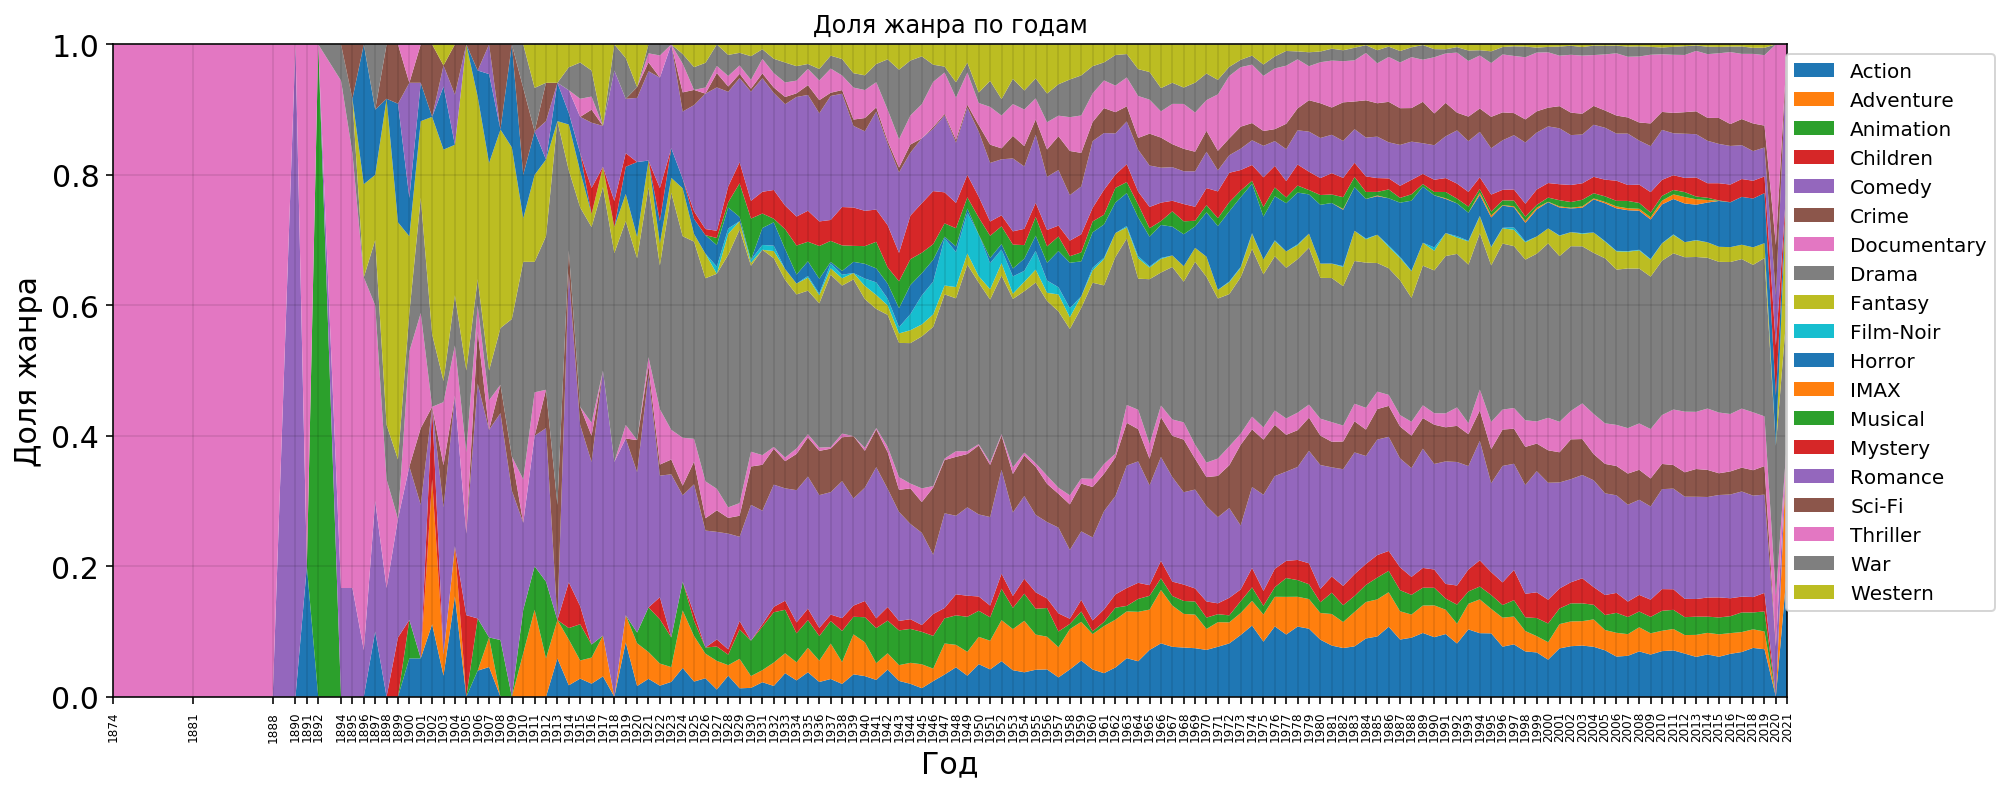

In [69]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(ticks = year, rotation=90, fontsize=6)
plt.yticks(fontsize=15)
plt.stackplot(year, df,labels=genre)
plt.xlim((year[0], year[-1] ))
plt.ylim((0, 1))
plt.title('Доля жанра по годам')
plt.xlabel('Год', fontsize=15)
plt.ylabel('Доля жанра', fontsize=15)
plt.legend(bbox_to_anchor=(1.13, 1))
plt.grid(color='black', alpha=0.1)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [70]:
######################################
######### YOUR CODE HERE #############
######################################

tmdb = sc.textFile(TMDB_PATH)

money = tmdb \
    .map(lambda s: json.loads(s))\
    .filter(lambda x: 'revenue' in x and "budget" in x)\
    .filter(lambda x: x["revenue"] >0 and x["budget"]>0)\
    .keyBy(lambda x: int(x['id']))\
    .mapValues(lambda x: (x["revenue"], x["budget"]))
    
    
money.take(3)

[(862, (373554033, 30000000)),
 (8844, (262797249, 65000000)),
 (31357, (81452156, 16000000))]

In [71]:
money = money.join(links)\
    .map(lambda x: (x[1][1], x[1][0]))
money.take(3)

[(18, (4257354, 4000000)),
 (923, (23217674, 839727)),
 (40278, (96889998, 72000000))]

In [72]:
money_genre = money.join(movies_genre).map(lambda x: (x[1][1], x[1][0]))
money_genre.take(3)

[('Comedy', (53672080, 58000000)),
 ('Romance', (53672080, 58000000)),
 ('Drama', (20138836, 12000000))]

In [73]:
ROI = money_genre \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda x: x[0] / x[1]) \
    .collect()

In [74]:
ROI[:3]

[('Action', 2.9645965082319843),
 ('Horror', 3.3423880902570464),
 ('Western', 1.8246852625591943)]

In [75]:
genres, roi = zip(*sorted(ROI, key= lambda x:x[1], reverse=True))

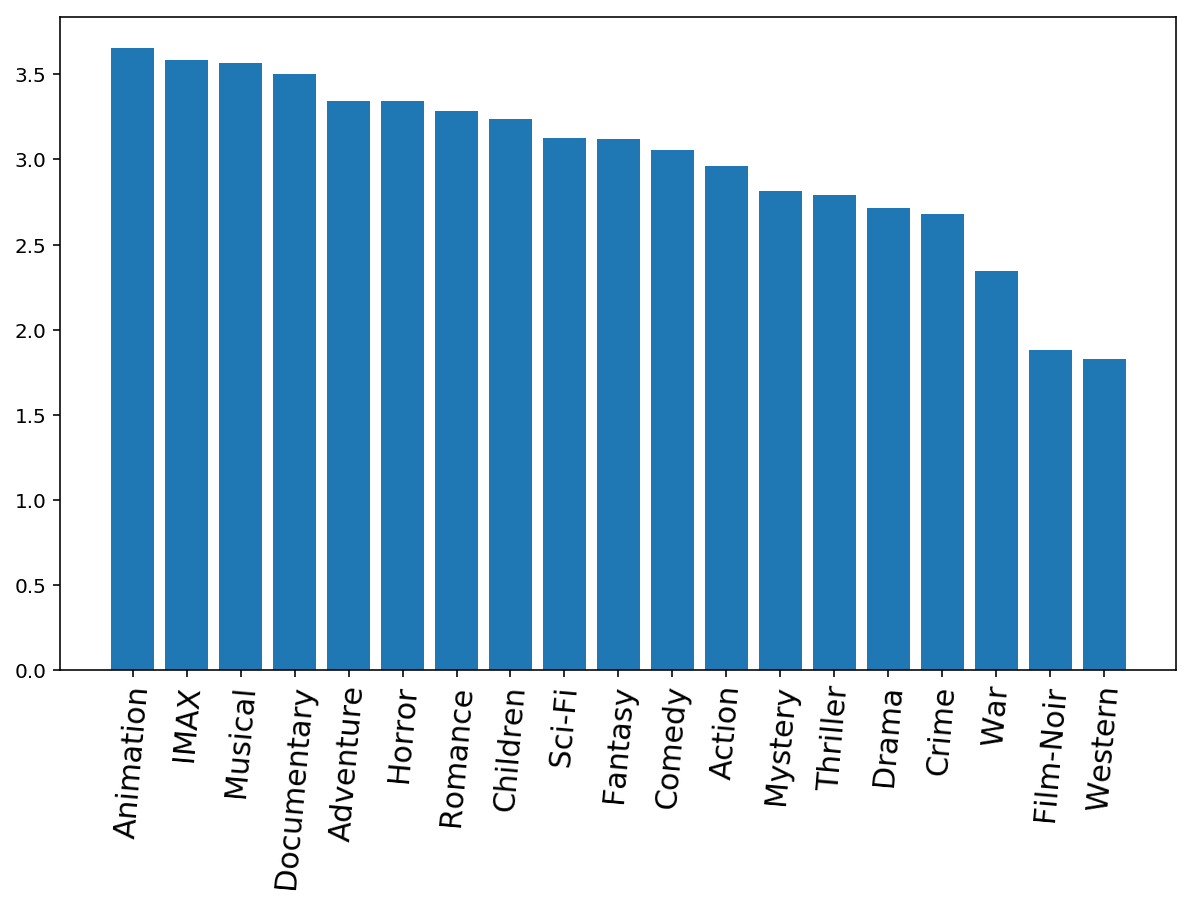

In [76]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, roi, align="center")
plt.show()